In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.1, style='whitegrid')

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

## code from [sklearn](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py)

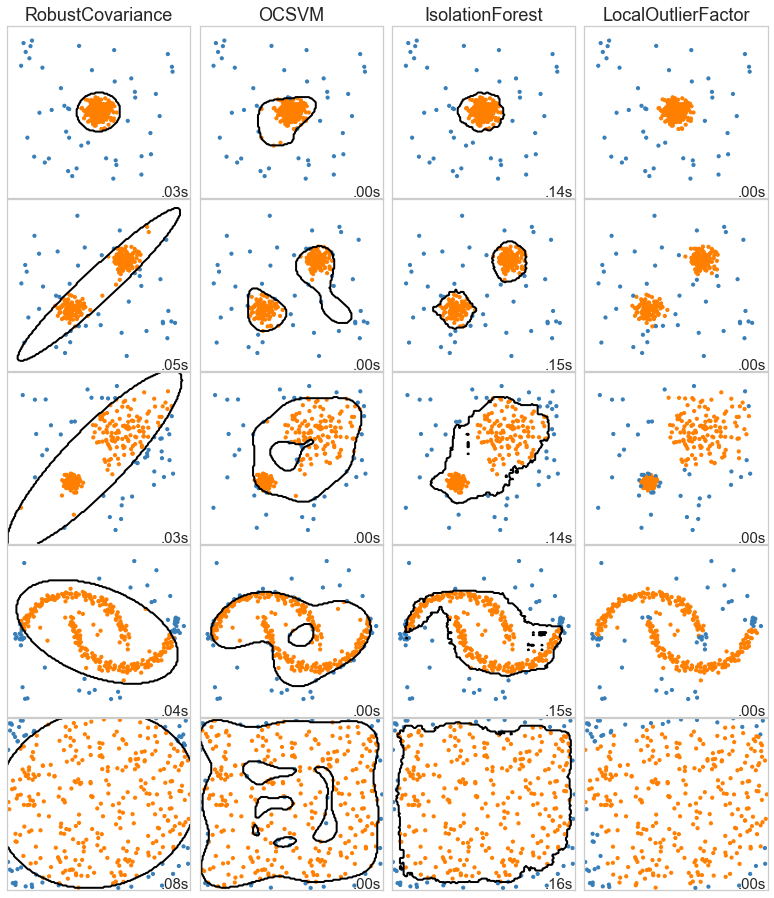

In [2]:
# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("RobustCovariance", EllipticEnvelope(
        contamination=outliers_fraction,
#         random_state=42,
    )),
    ("OCSVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    ("IsolationForest", IsolationForest(
        contamination=outliers_fraction, 
#         random_state=42
    )),
    ("LocalOutlierFactor", LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction))]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
               **blobs_params)[0],
    4. * (make_moons(n_samples=n_samples, noise=.05, random_state=0)[0] -
          np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_samples, 2) - 0.5)]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
rng = np.random.RandomState(42)

datasets_w_outliers = [
    np.concatenate([ds, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)
    for ds in datasets
]

for i_dataset, X in enumerate(datasets_w_outliers):
    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "LocalOutlierFactor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "LocalOutlierFactor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

### праверка abnormality:

Як прыводзіцца ў тым самым артыкуле з sklearn:

"Finally, for the last data set, it is hard to say that one sample is more abnormal than another sample as they are uniformly distributed in a hypercube. Except for the OneClassSVM which overfits a little, all estimators present decent solutions for this situation.

In such a case, it would be wise to look more closely at the scores of __abnormality of the samples__ as a good estimator should assign similar scores to all the samples."

Паспрабуем дастаць abnormality scores

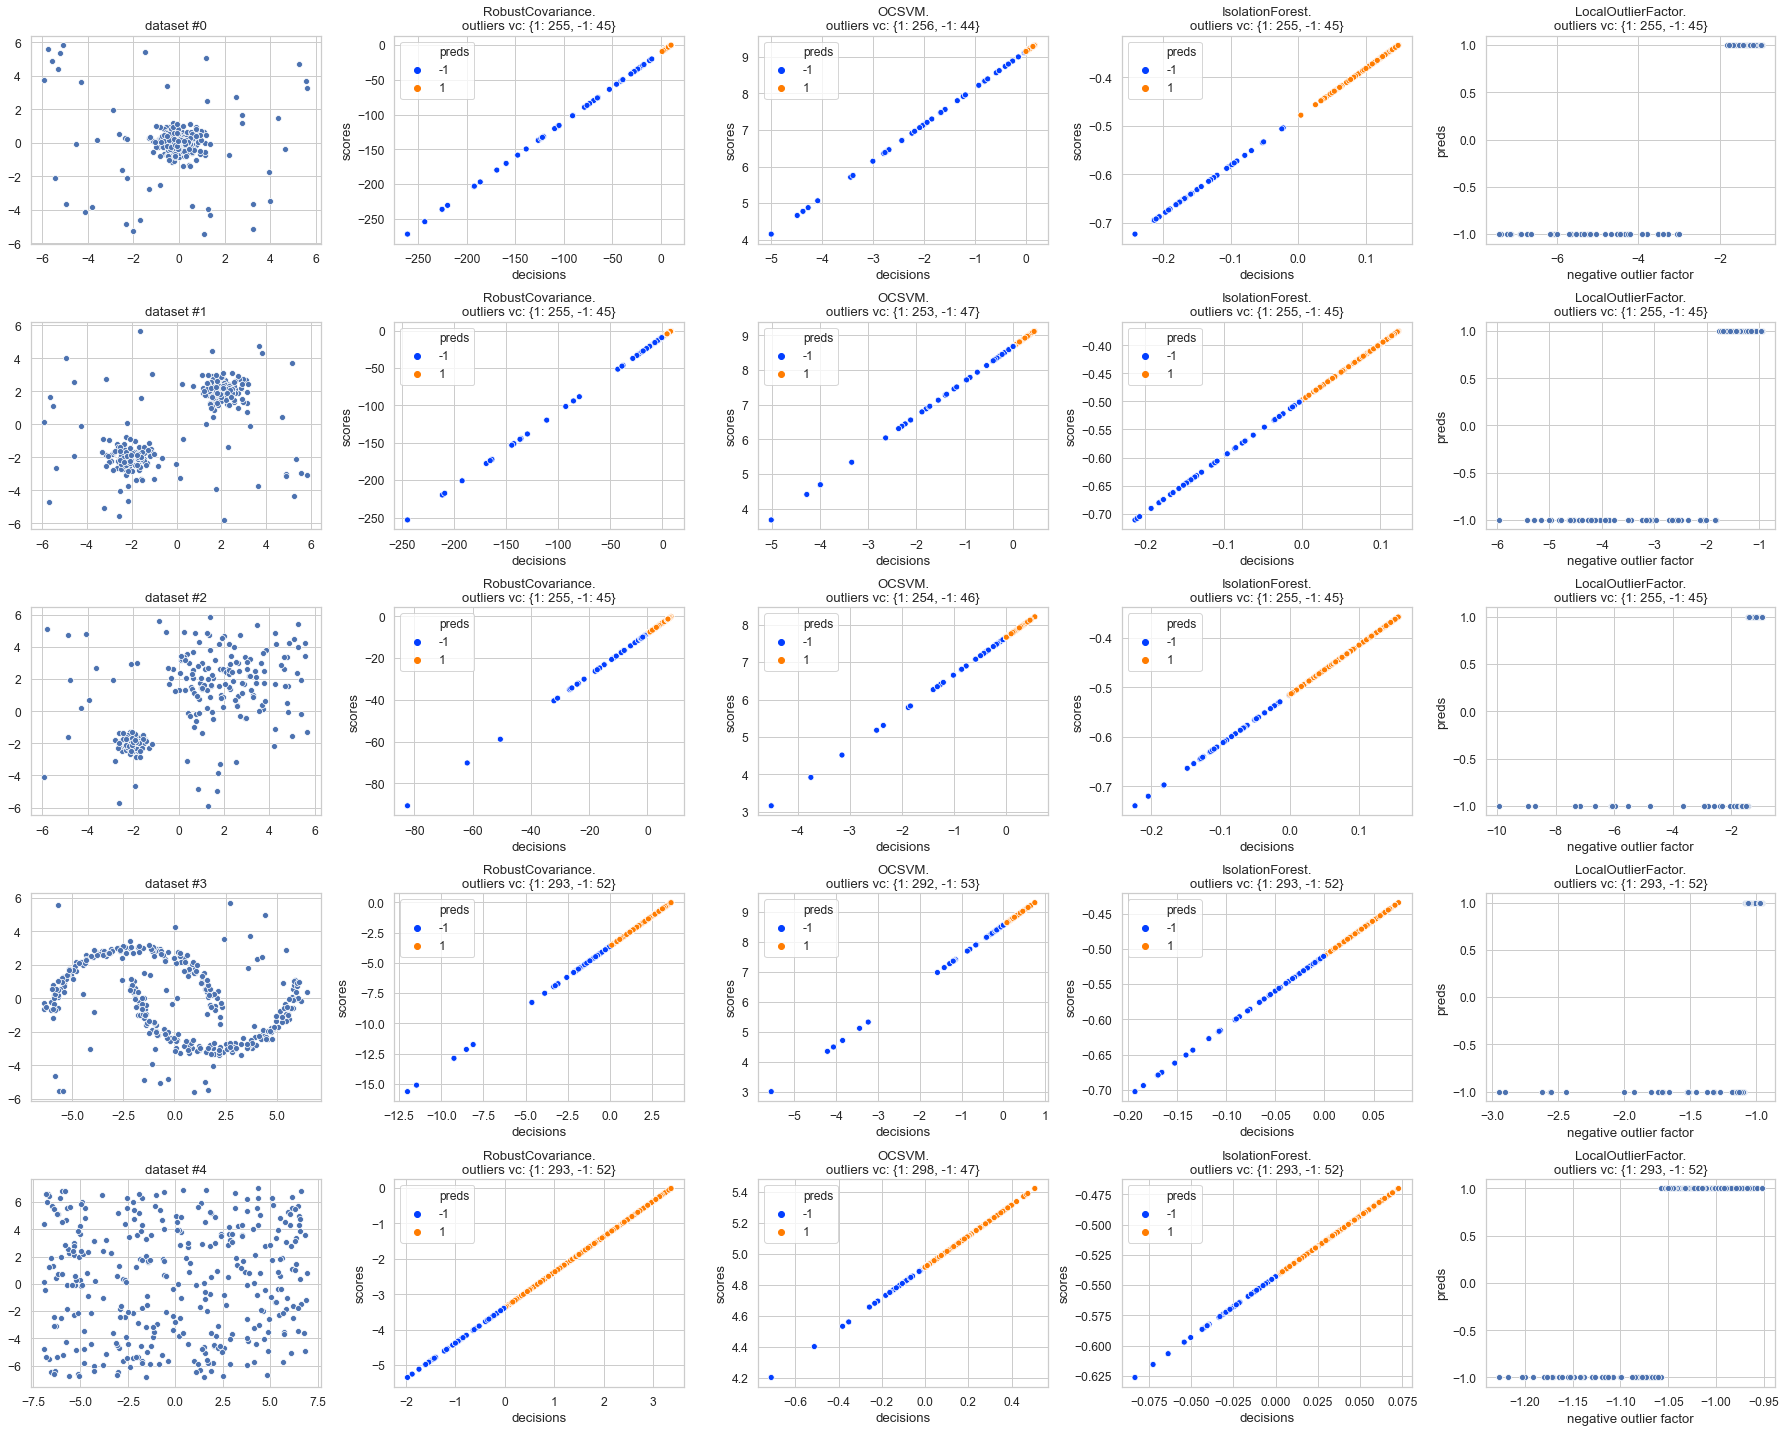

In [3]:
w, h = 5, 4
nrows, ncols = len(datasets_w_outliers), 5
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * w, nrows * h))

for i, _ds in enumerate(datasets_w_outliers):
    sns.scatterplot(x=_ds[:, 0], y=_ds[:, 1], ax=ax[i][0])
    ax[i][0].set_title(f'dataset #{i}')
    
    for j, (name, algo) in enumerate(anomaly_algorithms, start=1):
        x = pd.DataFrame(_ds, columns=['x1', 'x2'])
        x['preds'] = algo.fit_predict(x[['x1', 'x2']])
        
        if name != anomaly_algorithms[-1][0]: # not a LOF
            x['decisions'] = algo.decision_function(x[['x1', 'x2']])
            x['scores'] = algo.score_samples(x[['x1', 'x2']])
            sns.scatterplot(x='decisions', y='scores', hue='preds', data=x, palette='bright', ax=ax[i][j]);
        else:
            x['nof'] = algo.negative_outlier_factor_
            sns.scatterplot(x='nof', y='preds', data=x, ax=ax[i][j])
            ax[i][j].set_xlabel('negative outlier factor')
        
        vc = x["preds"].value_counts().to_dict()
        ax[i][j].set_title(f'{name}.\noutliers vc: {vc}');

fig.tight_layout();

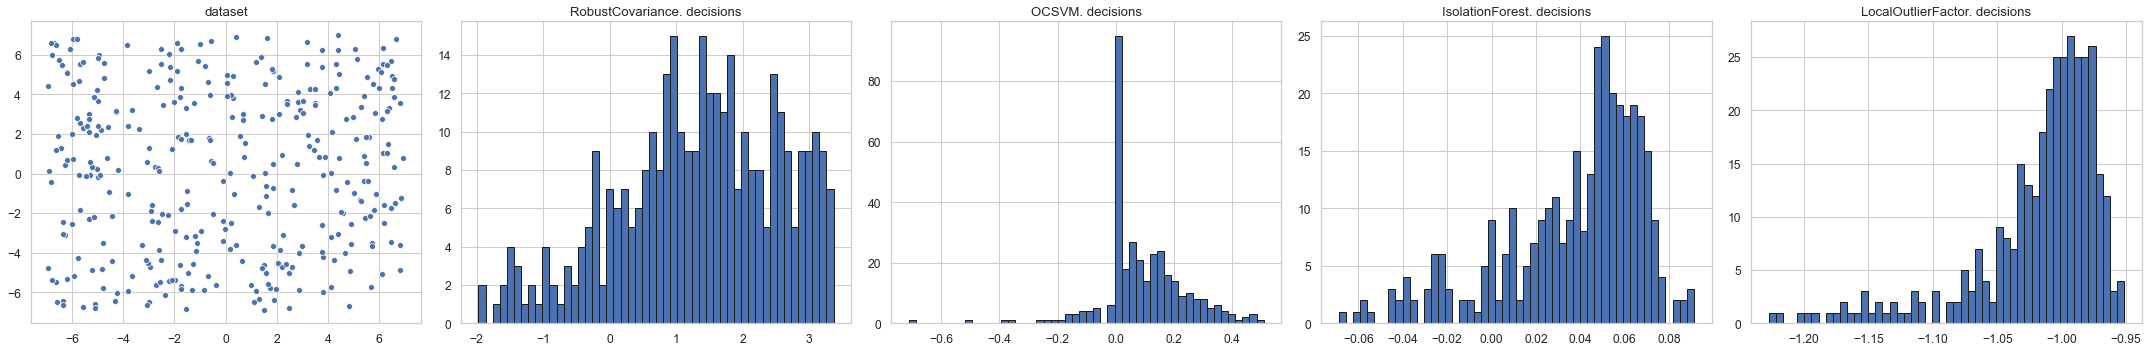

In [4]:
w, h = 6, 5
nrows, ncols = 1, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * w, nrows * h))
ax = ax.flatten()

_ds = datasets_w_outliers[-1]
sns.scatterplot(_ds[:, 0], _ds[:, 1], ax=ax[0])
ax[0].set_title('dataset')

for _ax, (name, algo) in zip(ax[1:], anomaly_algorithms):
    preds = algo.fit_predict(_ds)
    
    if name != anomaly_algorithms[-1][0]:
        decisions = algo.decision_function(_ds)
    else:
        decisions = algo.negative_outlier_factor_
    _ax.hist(decisions, edgecolor='k', bins=50)
    _ax.set_title(f'{name}. decisions');

plt.tight_layout();

### высновы:

* для ўсіх алгарытмаў акрамя LOF нармаванае значэньне `abnormality score` адпавядае `decision_function()`
    * для іх зыходнае значэньне можна атрымаць праз `score_samples()`
* для LOF велічыні `negative_outlier_factor_` адпавядаюць, відаць, зыходным `abnormality_scores`. 
    то бок да накладаньня парогу
* у LocalOultlierFactor, IsolationForest (і ў пэўнай ступені OCSVM) велічыні abnormality
  разьмеркаваны прыблізна аднолькава сярод усіх пунктаў: гістаграмы маюць шырокую моду 

## Візуалізацыя

### IsolationForest

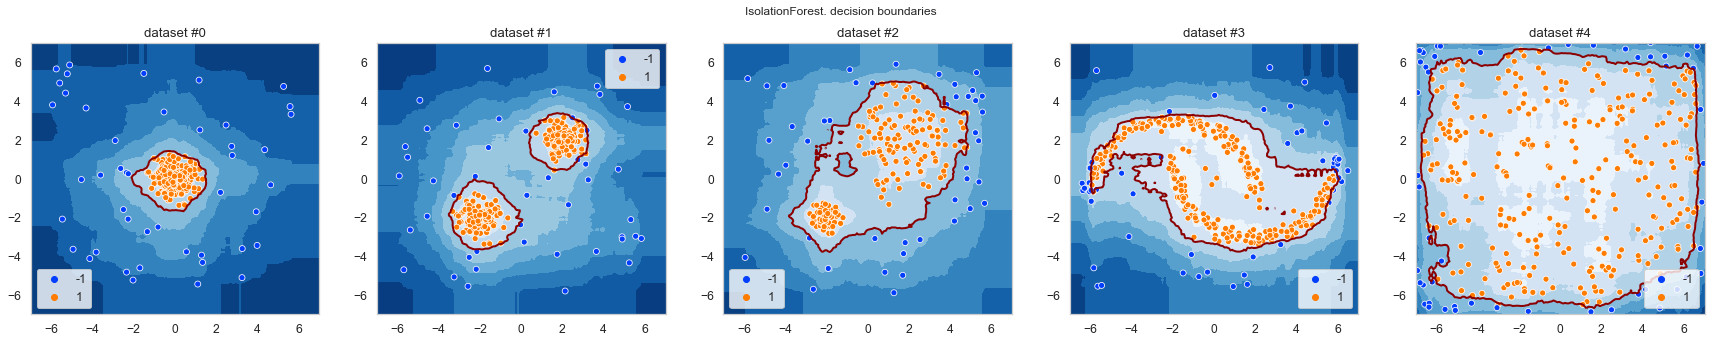

In [5]:
name, algo = anomaly_algorithms[2]

nrows, ncols = 1, len(datasets_w_outliers)
h, w = 5, 6
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * w, nrows * h))
fig.suptitle(f'{name}. decision boundaries')

xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

for i, _ds in enumerate(datasets_w_outliers):
    preds = algo.fit_predict(_ds)
    Z = algo.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax[i].set_title(f'dataset #{i}')
    ax[i].contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
    ax[i].contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    sns.scatterplot(_ds[:, 0], _ds[:, 1], hue=preds, palette='bright', ax=ax[i]);

### OCSVM

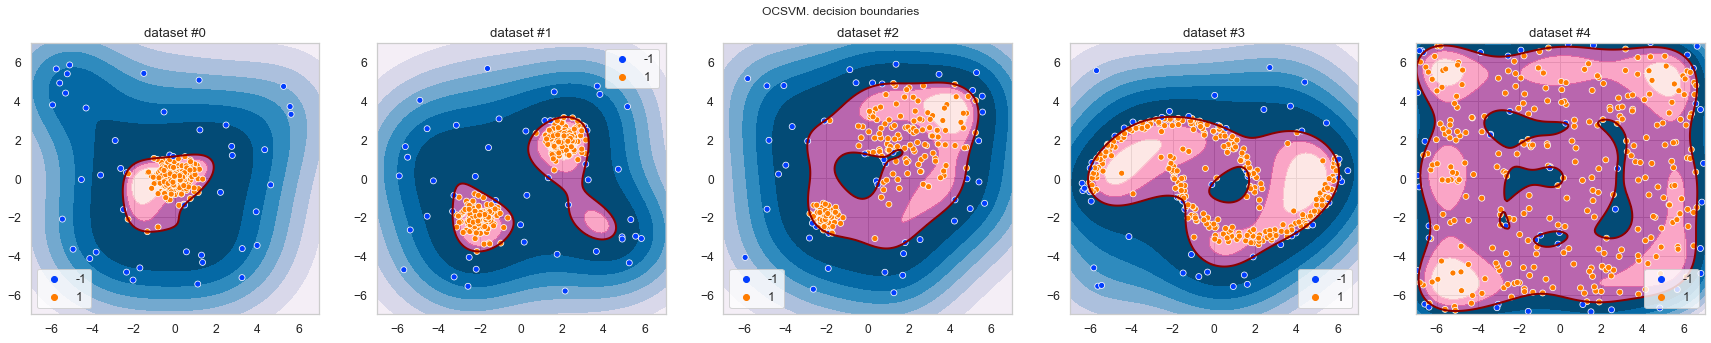

In [6]:
name, algo = anomaly_algorithms[1]

nrows, ncols = 1, len(datasets_w_outliers)
h, w = 5, 6
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * w, nrows * h))
fig.suptitle(f'{name}. decision boundaries')

xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

for i, _ds in enumerate(datasets_w_outliers):
    preds = algo.fit_predict(_ds)
    Z = algo.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax[i].set_title(f'dataset #{i}')
    ax[i].contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 8), cmap=plt.cm.PuBu)
    ax[i].contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    ax[i].contourf(xx, yy, Z, levels=np.linspace(0, Z.max(), 4), cmap=plt.cm.RdPu.reversed(), alpha=0.6)
    sns.scatterplot(_ds[:, 0], _ds[:, 1], hue=preds, palette='bright', ax=ax[i]);

## розныя рэзультаты пры пасьлядоўных запусках

* варта памятаць, што `EllipticEnvelope` і `IsolationForest` вяртаюць розныя рэзультаты 
  пры пасьлядоўных запусках, калі не задаць Random Seed

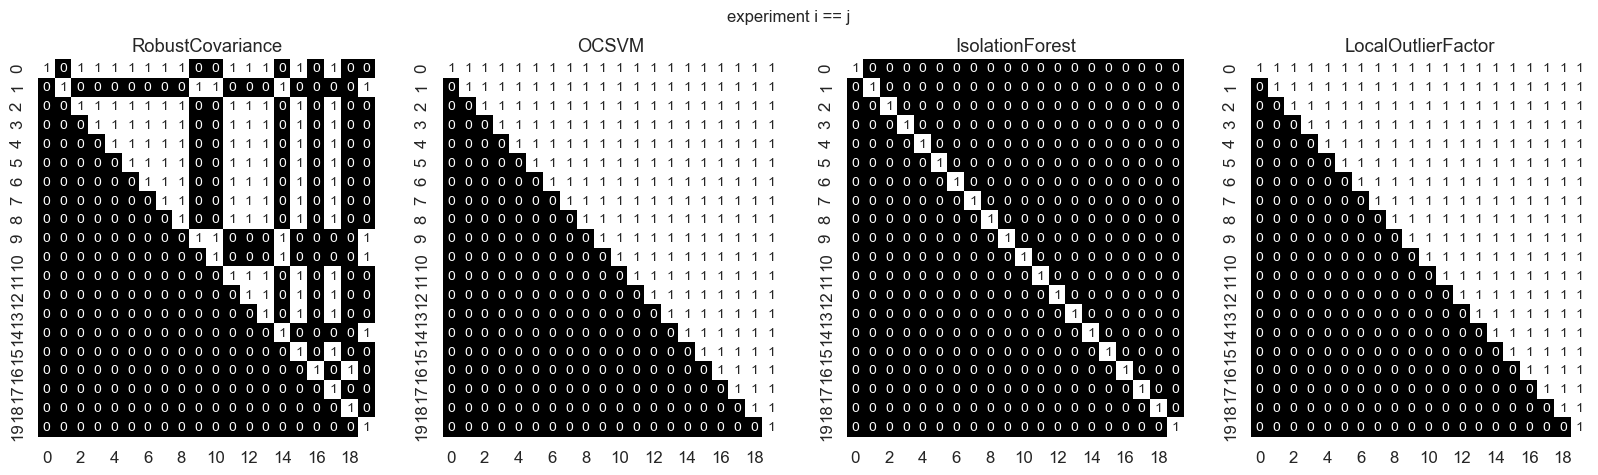

In [7]:
res = []
ntests = 20

for name, algo in anomaly_algorithms:
    
    check = pd.DataFrame(datasets_w_outliers[-1], columns=['x1', 'x2'])
    for i in range(ntests):
        algo.fit_predict(check[['x1', 'x2']])
        if not isinstance(algo, LocalOutlierFactor):
            check[f'ee_d{i}'] = algo.decision_function(check[['x1', 'x2']])
        else:
            check[f'ee_d{i}'] = algo.negative_outlier_factor_
        
    check2 = np.zeros(shape=(ntests, ntests))
    for i in range(ntests):
        for j in range(i, ntests):
            check2[i][j] = np.allclose(check[f'ee_d{i}'], check[f'ee_d{j}'])
    check2 = pd.DataFrame(check2).astype('int')
    
    res.append((name, check2))

nrows, ncols = 1, len(res)
fig, ax = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows), dpi=100)
for ax, (name, hm) in zip(ax, res):
    sns.heatmap(hm, cmap='gray', annot=True, cbar=False, ax=ax);
    ax.set_title(name);
fig.suptitle('experiment i == j');

* задамо Random Seed

In [8]:
for algo_ix, _type in zip([0, 2], [EllipticEnvelope, IsolationForest]):
    print(f'updating {anomaly_algorithms[algo_ix][0]}')
    prev_params = anomaly_algorithms[algo_ix][1].get_params()
    print(f'prev_params: {prev_params}')
    new_params = {**prev_params, **dict(random_state=42)}
    print(f'new params: {new_params}')
    anomaly_algorithms[algo_ix] = (f'{_type.__name__}_fixedSeed', _type(**new_params))
    print('----------------')

updating RobustCovariance
prev_params: {'assume_centered': False, 'contamination': 0.15, 'random_state': None, 'store_precision': True, 'support_fraction': None}
new params: {'assume_centered': False, 'contamination': 0.15, 'random_state': 42, 'store_precision': True, 'support_fraction': None}
----------------
updating IsolationForest
prev_params: {'behaviour': 'deprecated', 'bootstrap': False, 'contamination': 0.15, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': None, 'verbose': 0, 'warm_start': False}
new params: {'behaviour': 'deprecated', 'bootstrap': False, 'contamination': 0.15, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': 42, 'verbose': 0, 'warm_start': False}
----------------


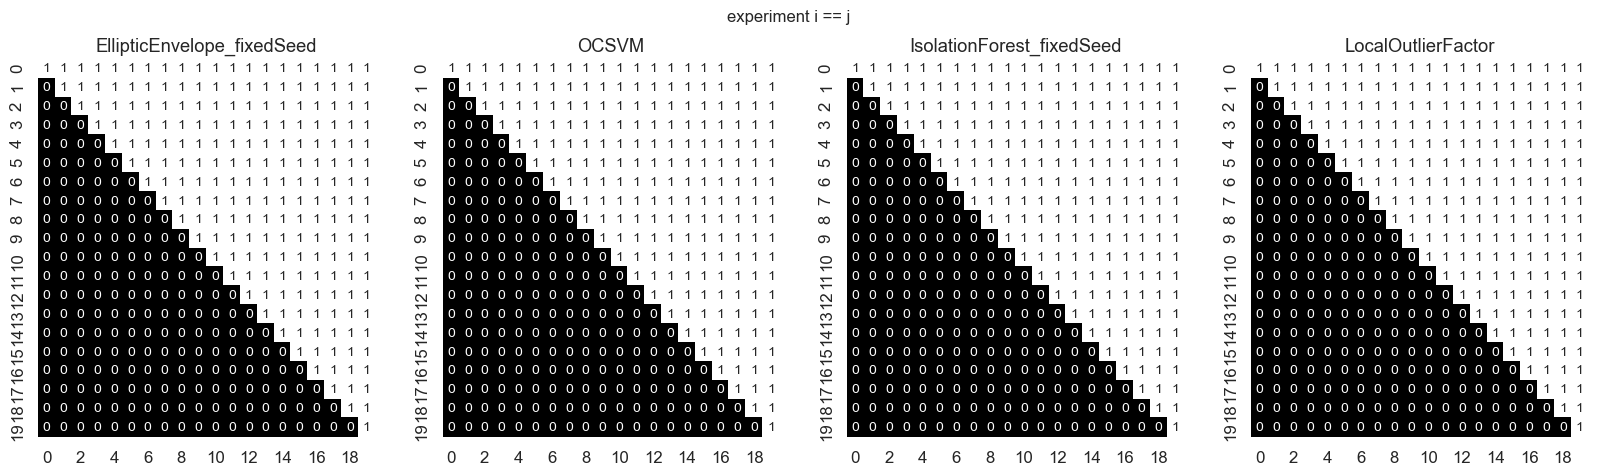

In [9]:
res = []
ntests = 20

for name, algo in anomaly_algorithms:
    
    check = pd.DataFrame(datasets_w_outliers[-1], columns=['x1', 'x2'])
    for i in range(ntests):
        algo.fit_predict(check[['x1', 'x2']])
        if not isinstance(algo, LocalOutlierFactor):
            check[f'ee_d{i}'] = algo.decision_function(check[['x1', 'x2']])
        else:
            check[f'ee_d{i}'] = algo.negative_outlier_factor_
        
    check2 = np.zeros(shape=(ntests, ntests))
    for i in range(ntests):
        for j in range(i, ntests):
            check2[i][j] = np.allclose(check[f'ee_d{i}'], check[f'ee_d{j}'])
    check2 = pd.DataFrame(check2).astype('int')
    
    res.append((name, check2))

nrows, ncols = 1, len(res)
fig, ax = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows), dpi=100)
for ax, (name, hm) in zip(ax, res):
    sns.heatmap(hm, cmap='gray', annot=True, cbar=False, ax=ax);
    ax.set_title(name);
fig.suptitle('experiment i == j');

* цяпер аднолькавыя